In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import torch
import torch.nn as nn
import torch.optim as optim

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.models import BlockRNNModel,TFTModel
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.likelihood_models import GaussianLikelihood
from darts.utils.missing_values import extract_subseries

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14, 9)})

import time # cpu time

import warnings
warnings.filterwarnings("ignore")

import logging
logging.disable(logging.CRITICAL)


In [2]:
def date_range(start, end):
    start_date = datetime.strptime(start, '%Y-%m-%d').date()
    end_date = datetime.strptime(end, '%Y-%m-%d').date()
    delta = end_date - start_date 
    days = [start_date + timedelta(days=i) for i in range(delta.days + 1)]
    return list(map(lambda n: n.strftime("%Y-%m-%d"), days))

#### load data

In [3]:
# set parameters
data_path = '/home/kth/Programming/python/tfvenv/data'
day_start = '2022-01-01'
day_end = '2023-06-30'
dates_list = date_range(day_start, day_end)
split_date = pd.Timestamp("20230501")


#### create time series from input data

In [11]:
# input time series data
df_all = pd.read_csv(f'input_time_series_{day_start}_{day_end}.csv')
display(df_all)


date  spcont_filtered    IL    IU    IE  cvalue  hour  \
0       2022-01-01 00:00:00              NaN -17.8  18.3  36.1   0.460     0   
1       2022-01-01 00:05:00              NaN -25.6  15.0  40.6   0.429     0   
2       2022-01-01 00:10:00              NaN -28.5  21.9  50.4   0.414     0   
3       2022-01-01 00:15:00              NaN -27.5  28.5  56.0   0.400     0   
4       2022-01-01 00:20:00              NaN -34.4  28.5  62.9   0.409     0   
...                     ...              ...   ...   ...   ...     ...   ...   
157243  2023-06-30 23:35:00              NaN -32.4  19.2  51.6   0.686    23   
157244  2023-06-30 23:40:00              NaN -34.5  17.0  51.5   0.676    23   
157245  2023-06-30 23:45:00              NaN -35.4  18.4  53.8   0.733    23   
157246  2023-06-30 23:50:00              NaN -18.8  17.4  36.2   0.734    23   
157247  2023-06-30 23:55:00              NaN  -8.4  19.9  28.3   0.698    23   

        month   mask  
0           1  False  
1           1  False  
2           1  False  
3           1  False  
4           1  False  
...       ...    ...  
157243      6  False  
157244      6  False  
157245      6  False  
157246      6  False  
157247      6  False  

[157248 rows x 9 columns]

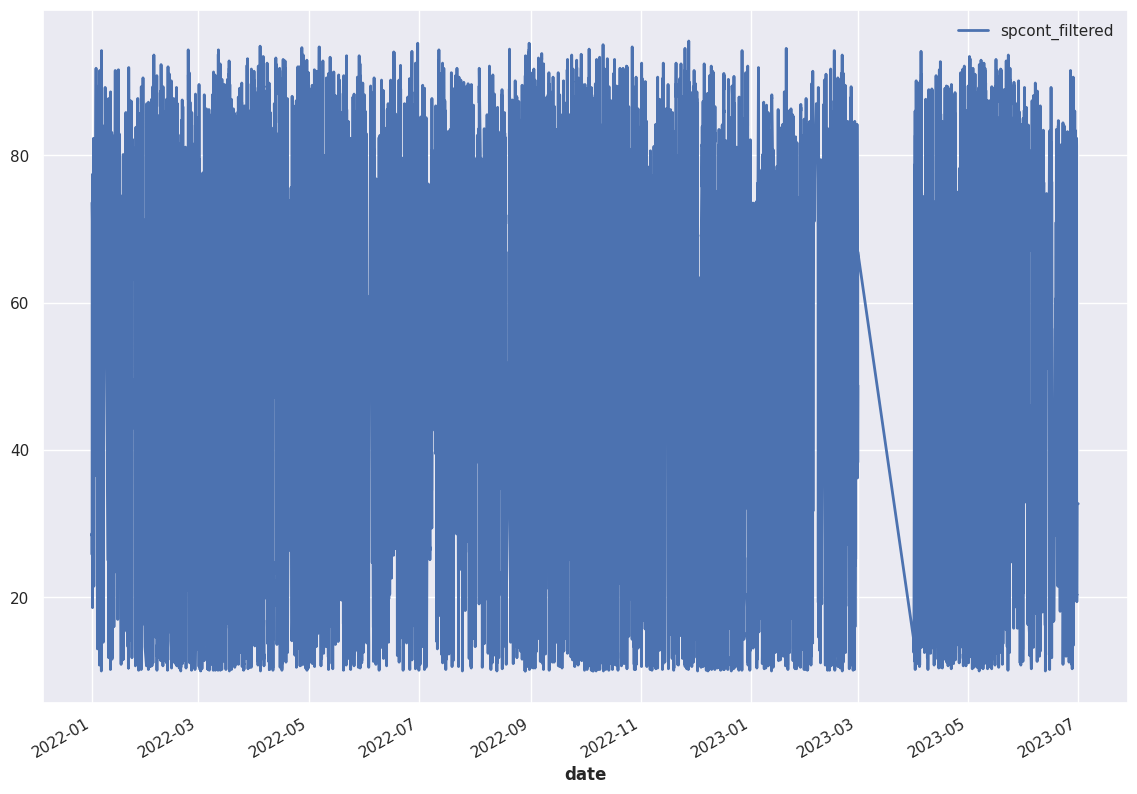

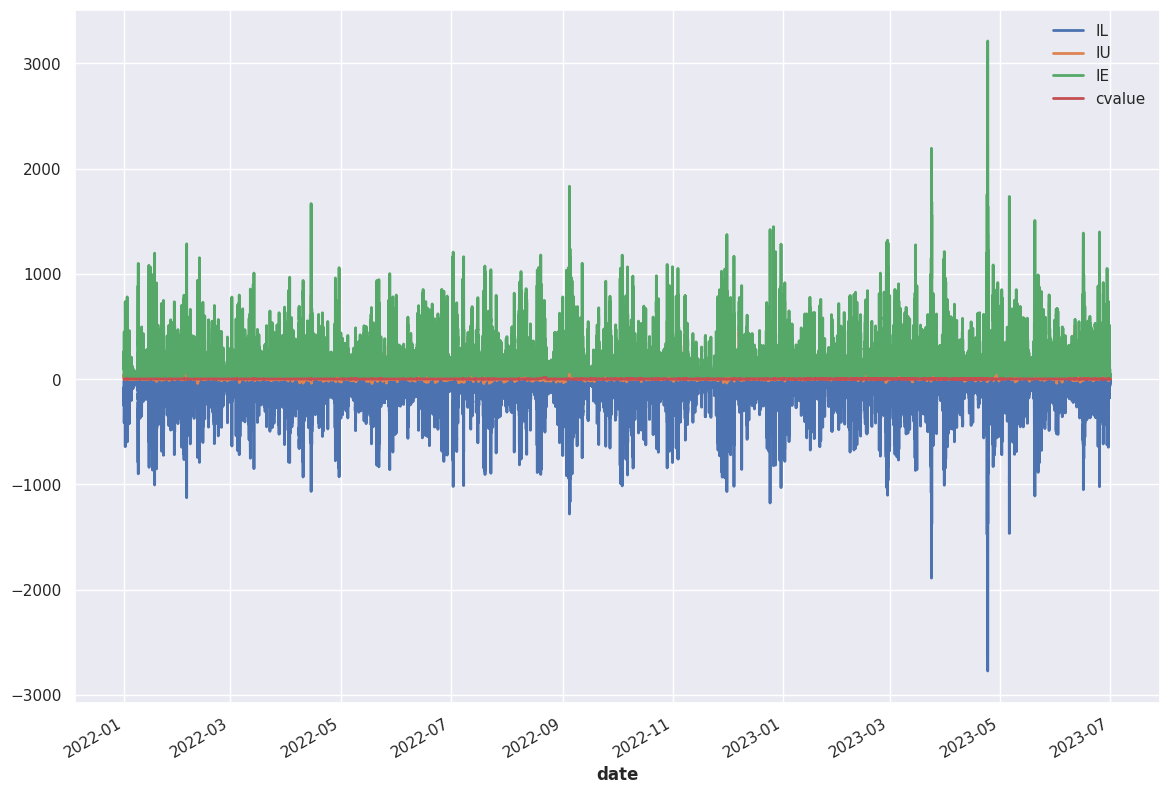

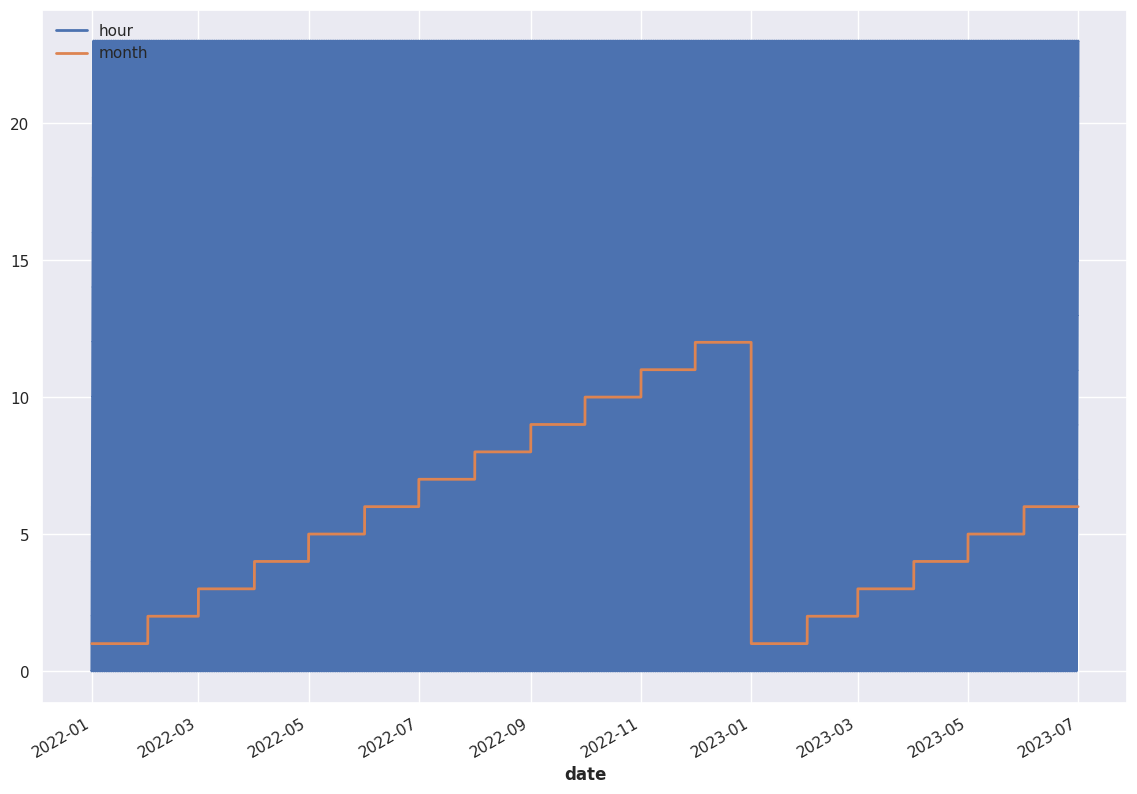

In [12]:
# create and fill target time series
ts_spcont = TimeSeries.from_dataframe(df_all, 
                                      time_col='date',
                                      value_cols=['spcont_filtered']
                                     ) 

transformer_spcont = MissingValuesFiller()
ts_spcont_filled = transformer_spcont.transform(ts_spcont)
ts_spcont_filled.plot()
plt.show()

# create and fill past covariates
ts_pastcovs = TimeSeries.from_dataframe(df_all,
                                        time_col='date',
                                        value_cols=['IL', 'IU', 'IE', 'cvalue'] 
                                       ) 
transformer_past = MissingValuesFiller()
ts_pastcovs_filled = transformer_past.transform(ts_pastcovs)
ts_pastcovs_filled.plot()
plt.show()

# create and fill future covariates
ts_futcovs = TimeSeries.from_dataframe(df_all,
                                       time_col='date',
                                       value_cols=['hour', 'month']
                                      ) 
ts_futcovs.plot()
plt.show()

In [13]:
# print(ts_tid.n_components)

In [14]:
# print(ts_covs.top_level_component, ts_covs.n_components)
# ts_covs.plot(new_plot=True, ax=2, max_nr_components=2)

#### time series preprocessing 

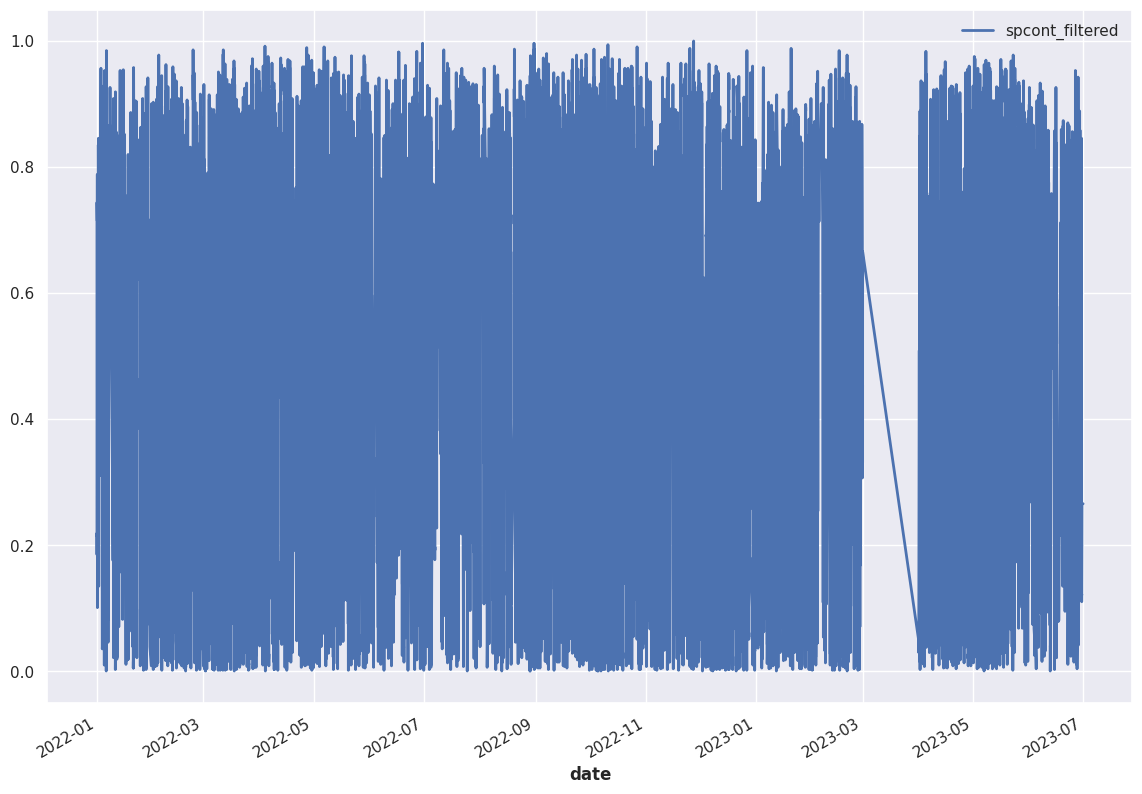

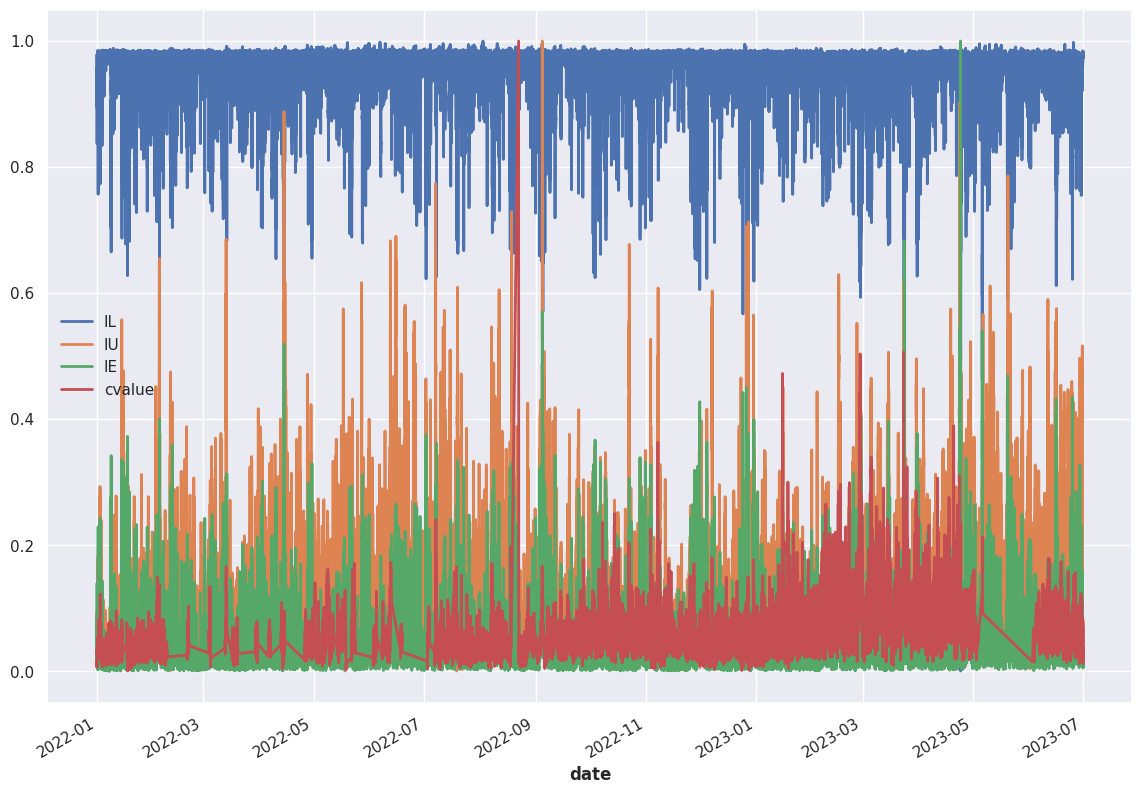

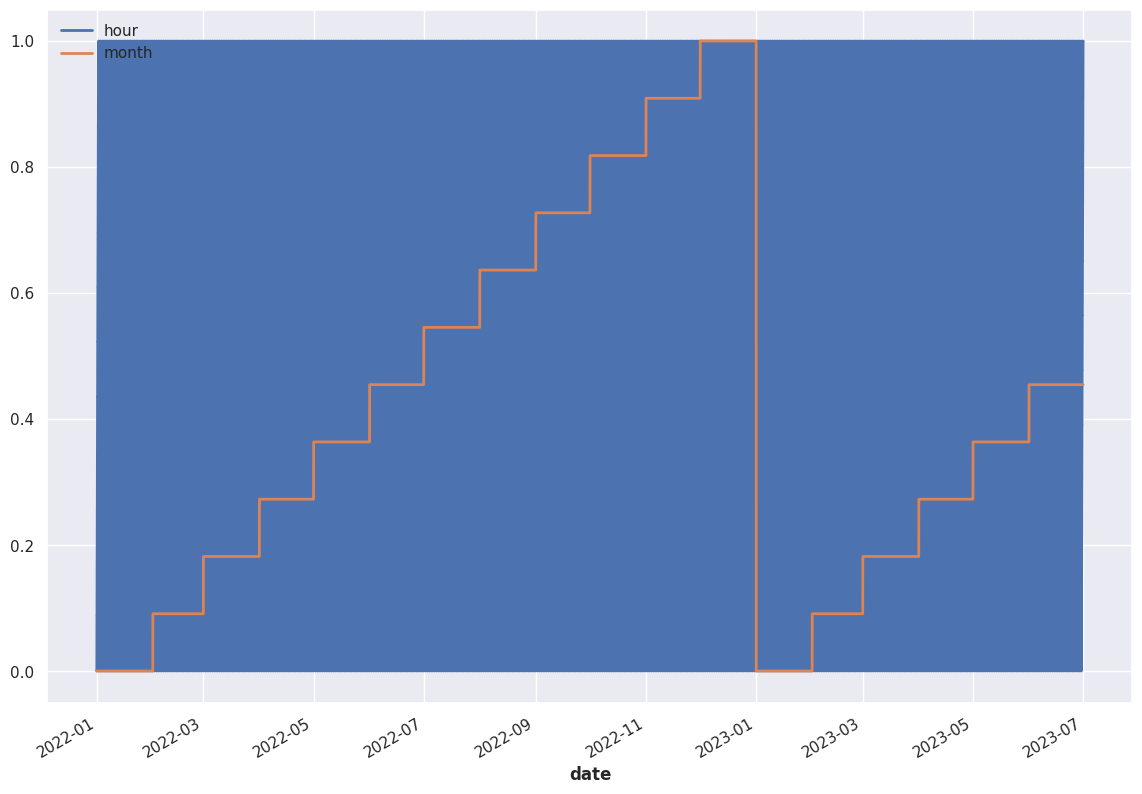

In [15]:
scaler_spcont, scaler_pastcovs, scaler_futcovs = Scaler(), Scaler(), Scaler()
ts_spcont_scaled = scaler_spcont.fit_transform(ts_spcont_filled)
ts_spcont_scaled.plot()
plt.show()

ts_pastcovs_scaled = scaler_pastcovs.fit_transform(ts_pastcovs_filled)
ts_pastcovs_scaled.plot()
plt.show()

ts_futcovs_scaled = scaler_futcovs.fit_transform(ts_futcovs)
ts_futcovs_scaled.plot()
plt.show()

#### train / validation split

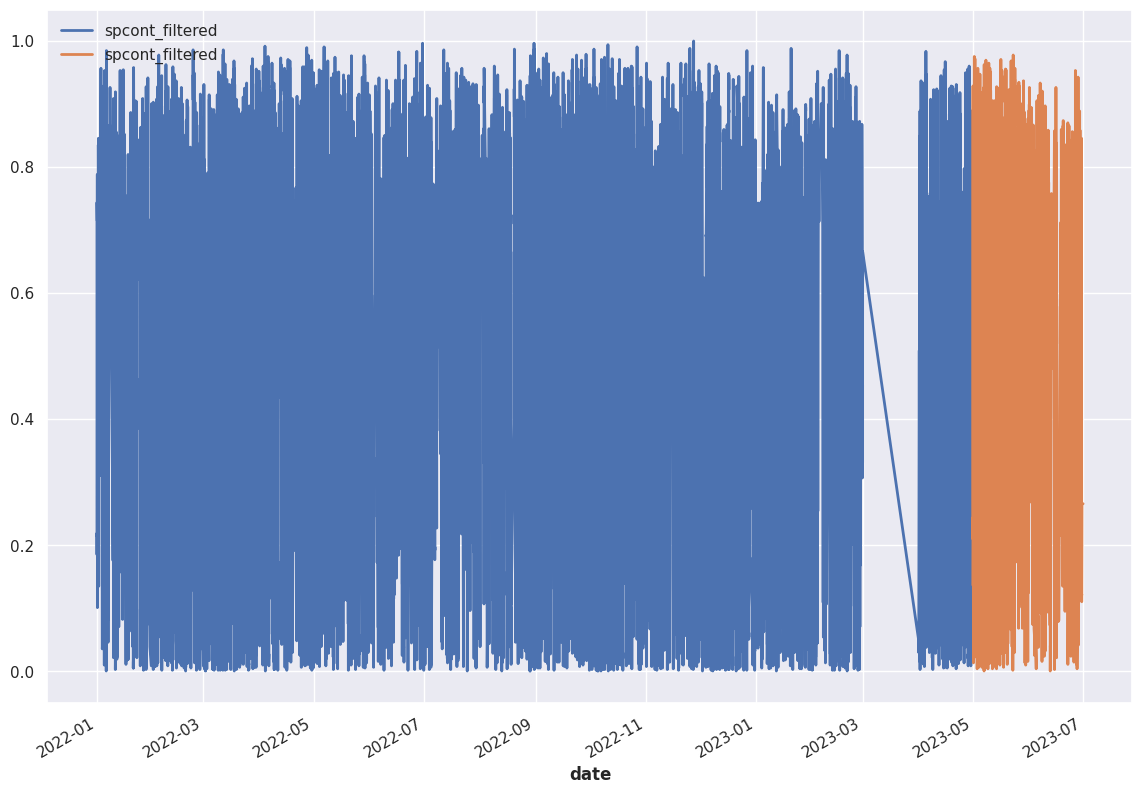

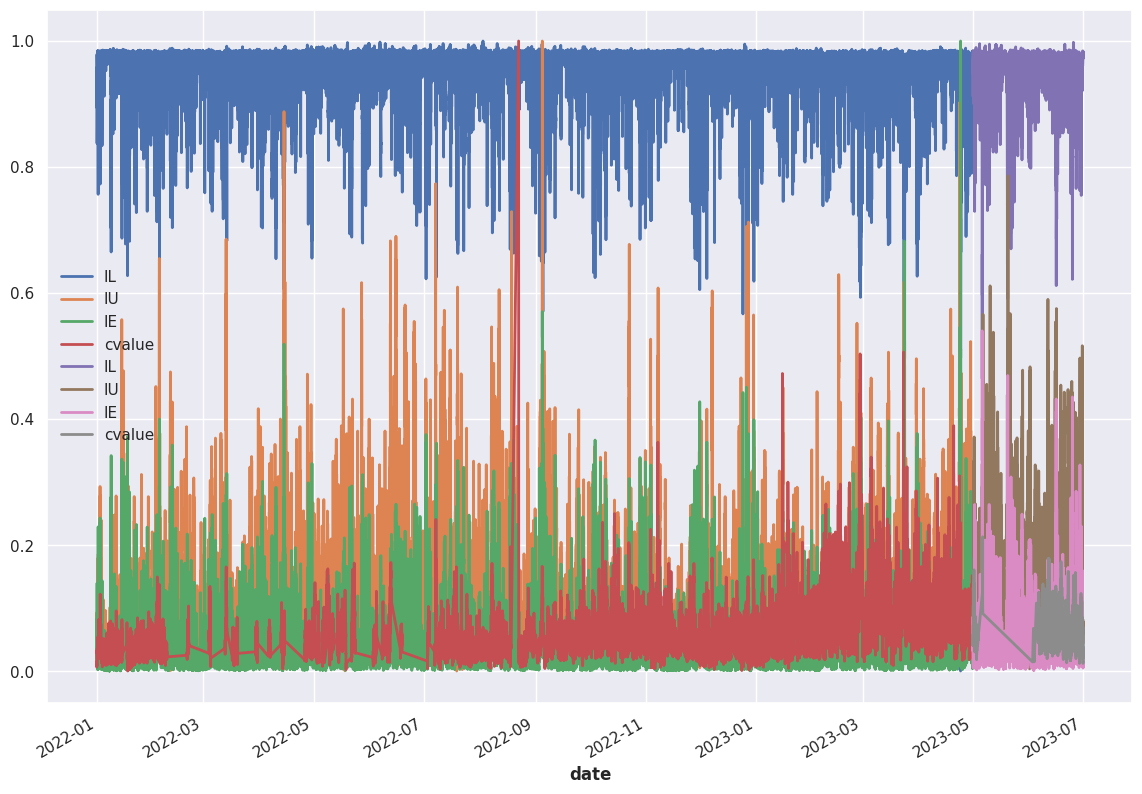

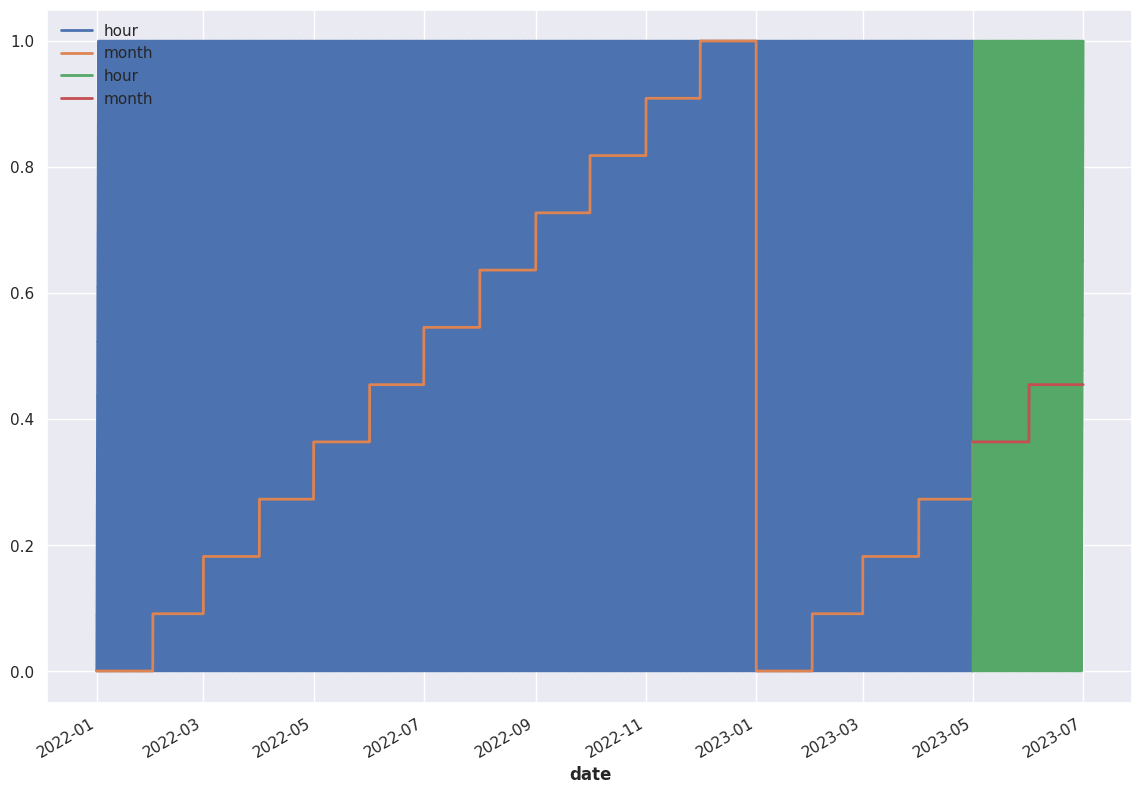

In [16]:
# split
train_spcont, val_spcont = ts_spcont_scaled.split_after(split_date)
train_spcont.plot()
val_spcont.plot()
plt.show()

train_pastcovs, val_pastcovs = ts_pastcovs_scaled.split_after(split_date)
train_pastcovs.plot()
val_pastcovs.plot()
plt.show()

train_futcovs, val_futcovs = ts_futcovs_scaled.split_after(split_date)
train_futcovs.plot()
val_futcovs.plot()
plt.show()

# get valid samples indexes in validation set
ts_mask = TimeSeries.from_dataframe(df_all, time_col='date', value_cols='mask')
train_mask, val_mask = ts_mask.split_after(split_date)


#### train model

In [17]:
# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

tft_model = TFTModel(hidden_size=128,
                     dropout=0.05,
                     n_epochs=128,
                     batch_size=1024,
                     lstm_layers=1,
                     num_attention_heads=2,
                     full_attention=False,
                     input_chunk_length=36,
                     output_chunk_length=1, 
                     use_static_covariates=False, 
                     pl_trainer_kwargs={"accelerator": "cpu", "callbacks": [my_stopper]},
                     show_warnings=False
                    )

In [18]:
# fitting model with past and future covariates
t0 = time.time()
tft_model.fit(series=train_spcont, 
              past_covariates=train_pastcovs, 
              future_covariates=train_futcovs, 
              verbose=False)
print("Training time:", time.time()-t0)

Training time: 3487.7619273662567


In [19]:
# train rnn model
block_rnn_model = BlockRNNModel(model="LSTM", hidden_dim=24, n_rnn_layers=2, dropout=0.1,
                                batch_size=1024, n_epochs=128, optimizer_kwargs={"lr": 1e-3},
                                random_state=0, 
                                input_chunk_length=36,
                                output_chunk_length=1, 
                                pl_trainer_kwargs={"accelerator": "cpu"},
                                show_warnings=False,
                                likelihood=GaussianLikelihood()
                               )

In [20]:
# fitting model with past  covariates
t0 = time.time()
block_rnn_model.fit(series=train_spcont, 
                    past_covariates=train_pastcovs, 
                    verbose=False)
print("Training time:", time.time()-t0)

Training time: 3279.7978699207306


#### evaluate performance


In [21]:
# set parameters
df_metrics = pd.DataFrame()
forecast_horizon = [1, 4, 8, 12] #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] # 
thresholds = [.5, .7] # [.5] #


In [22]:
# tft model
for hrz in forecast_horizon:
    print('horizon, ', hrz)
    tft_model_backtest = tft_model.historical_forecasts(series=val_spcont,
                                                        past_covariates=val_pastcovs,
                                                        future_covariates=val_futcovs,
                                                        start=None, 
                                                        num_samples=10,
                                                        forecast_horizon=hrz,
                                                        stride=1,
                                                        retrain=False,
                                                        verbose=False
                                                       )
    
    for thr in thresholds:
        
        val_time = tft_model_backtest.start_time() + pd.Timedelta(minutes=5)

        y_true = np.digitize(val_spcont.drop_before(val_time).values(), np.array([thr]), right=False)        
        y_pred = np.digitize(tft_model_backtest.drop_before(val_time).mean().values(), np.array([thr]), right=False)

        # get indexes of original spcont samples in validation set
        y_ind = np.where(val_mask.drop_before(val_time).values())[0]
        
        row_to_append = pd.DataFrame({'model': ['TFTModel_hd128_ch36_drop01_ep256_ll1_batch1024_atth4_fullattFalse'],
                                      'forecast horizon': [hrz],
                                      'theta' : [thr], 
                                      'f1-weighted' : [f1_score(y_true[y_ind], y_pred[y_ind], average='binary')]
                                     })

        df_metrics = pd.concat([df_metrics, row_to_append], ignore_index=True)

display(df_metrics)

horizon,  1
horizon,  4
horizon,  8
horizon,  12


model  forecast horizon  theta  \
0  TFTModel_hd128_ch36_drop01_ep256_ll1_batch1024...                 1    0.5   
1  TFTModel_hd128_ch36_drop01_ep256_ll1_batch1024...                 1    0.7   
2  TFTModel_hd128_ch36_drop01_ep256_ll1_batch1024...                 4    0.5   
3  TFTModel_hd128_ch36_drop01_ep256_ll1_batch1024...                 4    0.7   
4  TFTModel_hd128_ch36_drop01_ep256_ll1_batch1024...                 8    0.5   
5  TFTModel_hd128_ch36_drop01_ep256_ll1_batch1024...                 8    0.7   
6  TFTModel_hd128_ch36_drop01_ep256_ll1_batch1024...                12    0.5   
7  TFTModel_hd128_ch36_drop01_ep256_ll1_batch1024...                12    0.7   

   f1-weighted  
0     0.968966  
1     0.949910  
2     0.900371  
3     0.841515  
4     0.815412  
5     0.723187  
6     0.754558  
7     0.605499

In [23]:
# rnn model
for hrz in forecast_horizon:
    print('horizon, ', hrz)
    rnn_model_backtest = block_rnn_model.historical_forecasts(series=val_spcont,
                                                        past_covariates=val_pastcovs,
                                                        start=None, 
                                                        num_samples=10,
                                                        forecast_horizon=hrz,
                                                        stride=1,
                                                        retrain=False,
                                                        verbose=False
                                                       )
    
    for thr in thresholds:
        
        val_time = rnn_model_backtest.start_time() + pd.Timedelta(minutes=5)

        y_true = np.digitize(val_spcont.drop_before(val_time).values(), np.array([thr]), right=False)        
        y_pred = np.digitize(rnn_model_backtest.drop_before(val_time).mean().values(), np.array([thr]), right=False)

        # get indexes of original spcont samples in validation set
        y_ind = np.where(val_mask.drop_before(val_time).values())[0]
        
        row_to_append = pd.DataFrame({'model': ['BlockRNNModel_hd72_ch36_drop01_ep256_ll2_batch1024'],
                                      'forecast horizon': [hrz],
                                      'theta' : [thr], 
                                      'f1-weighted' : [f1_score(y_true[y_ind], y_pred[y_ind], average='binary')]
                                     })

        df_metrics = pd.concat([df_metrics, row_to_append], ignore_index=True)

display(df_metrics)

horizon,  1
horizon,  4
horizon,  8
horizon,  12


model  forecast horizon  \
0   TFTModel_hd128_ch36_drop01_ep256_ll1_batch1024...                 1   
1   TFTModel_hd128_ch36_drop01_ep256_ll1_batch1024...                 1   
2   TFTModel_hd128_ch36_drop01_ep256_ll1_batch1024...                 4   
3   TFTModel_hd128_ch36_drop01_ep256_ll1_batch1024...                 4   
4   TFTModel_hd128_ch36_drop01_ep256_ll1_batch1024...                 8   
5   TFTModel_hd128_ch36_drop01_ep256_ll1_batch1024...                 8   
6   TFTModel_hd128_ch36_drop01_ep256_ll1_batch1024...                12   
7   TFTModel_hd128_ch36_drop01_ep256_ll1_batch1024...                12   
8   BlockRNNModel_hd72_ch36_drop01_ep256_ll2_batch...                 1   
9   BlockRNNModel_hd72_ch36_drop01_ep256_ll2_batch...                 1   
10  BlockRNNModel_hd72_ch36_drop01_ep256_ll2_batch...                 4   
11  BlockRNNModel_hd72_ch36_drop01_ep256_ll2_batch...                 4   
12  BlockRNNModel_hd72_ch36_drop01_ep256_ll2_batch...                 8   
13  BlockRNNModel_hd72_ch36_drop01_ep256_ll2_batch...                 8   
14  BlockRNNModel_hd72_ch36_drop01_ep256_ll2_batch...                12   
15  BlockRNNModel_hd72_ch36_drop01_ep256_ll2_batch...                12   

    theta  f1-weighted  
0     0.5     0.968966  
1     0.7     0.949910  
2     0.5     0.900371  
3     0.7     0.841515  
4     0.5     0.815412  
5     0.7     0.723187  
6     0.5     0.754558  
7     0.7     0.605499  
8     0.5     0.966391  
9     0.7     0.939642  
10    0.5     0.880777  
11    0.7     0.630537  
12    0.5     0.741370  
13    0.7     0.182524  
14    0.5     0.629408  
15    0.7     0.050456

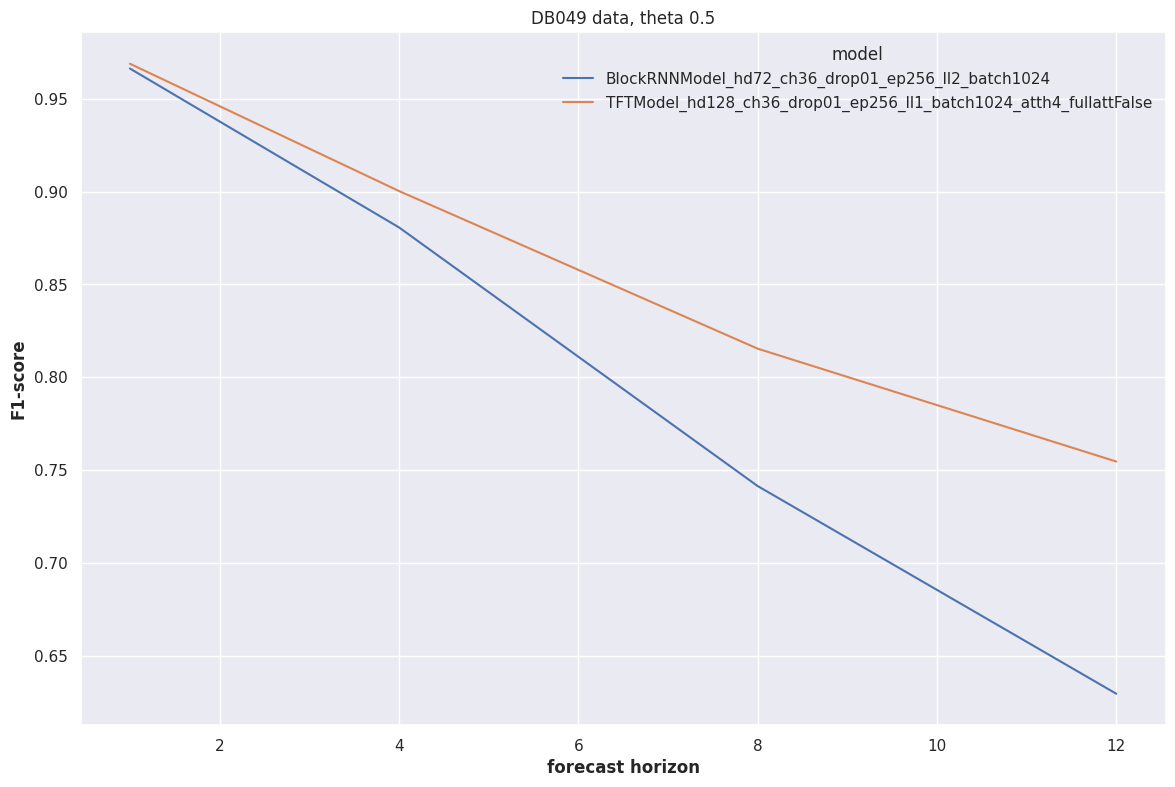

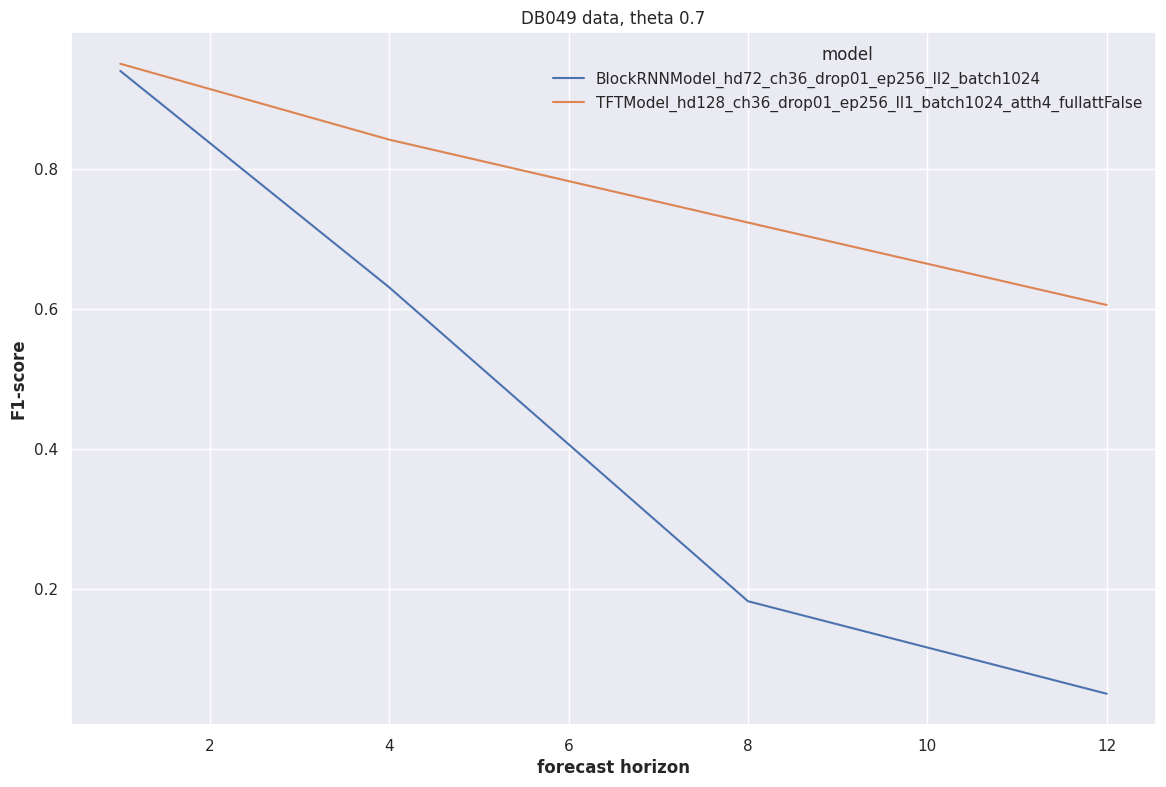

In [24]:
for thr in thresholds:
    fig, ax = plt.subplots()
    df_m1 = df_metrics[(df_metrics['theta']==thr)]
    df_m1 = df_m1[['model', 'forecast horizon', 'f1-weighted']]
    df_m1 = df_m1.pivot(index='forecast horizon', columns='model', values='f1-weighted')
    df_m1.plot.line(ax=ax)
    ax.set_ylabel('F1-score')
    ax.set_title(f'DB049 data, theta {thr}')
    plt.savefig(f'{data_path}/to_send/TFTmodels_comparison_DB049_thr{thr}.png', bbox_inches ="tight")
    plt.show()

____